## Check HW








In [ ]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  2
  On-line CPU(s) list:   0,1
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:          6
    Model:               79
    Thread(s) per core:  2
    Core(s) per socket:  1
    Socket(s):           1
    Stepping:            0
    BogoMIPS:            4399.99
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clf
                         lush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_
                         good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fm
                         a cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hyp
                         ervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd i

In [ ]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            12Gi       754Mi       9.6Gi       1.0Mi       2.4Gi        11Gi
Swap:             0B          0B          0B


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!nvidia-smi

Mon Oct 23 19:55:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install the environment

In [ ]:
#!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

In [ ]:
!rm -rf master.zip* nvcc4jupyter-master*
!wget https://github.com/andreinechaev/nvcc4jupyter/archive/refs/heads/master.zip
!unzip master.zip
!cd nvcc4jupyter-master; ls; pip install .

--2023-10-23 19:55:03--  https://github.com/andreinechaev/nvcc4jupyter/archive/refs/heads/master.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/andreinechaev/nvcc4jupyter/zip/refs/heads/master [following]
--2023-10-23 19:55:03--  https://codeload.github.com/andreinechaev/nvcc4jupyter/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 192.30.255.120
Connecting to codeload.github.com (codeload.github.com)|192.30.255.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ]   5.08K  --.-KB/s    in 0s      

2023-10-23 19:55:04 (63.7 MB/s) - ‘master.zip’ saved [5206]

Archive:  master.zip
0a71d56e5dce3ff1f0dd2c47c29367629262f527
   creating: nvcc4jupyter-master/
 extracting: nvc

In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


## Run a program (using Google overpowered GPUs)



### Simple mode, everything on the same file

This is the only part of the notebook that really uses the extension nvcc_plugin

In [ ]:
%%cu

#include <stdio.h>
#include <cuda.h>
#include <cuda_runtime.h>

__global__ void mykernel(void) {

}

int main(void) {
		mykernel<<<1,1>>>();
		printf("Hello world\n");
		return 0;
}

Hello world



In [ ]:
%%cu
#include <cuda.h>
#include <cuda_runtime.h>
#include <stdio.h>

__global__ void add(int *a, int *b, int *c) {
    *c = *a + *b;
}

int main(void) {
    int a, b, c;				    // host copies of a, b, c
	  int *d_a, *d_b, *d_c;		// device copies of a, b, c
	  int size = sizeof(int);

	  // Allocate space for device copies of a, b, c
	  cudaMalloc((void **)&d_a, size);
	  cudaMalloc((void **)&d_b, size);
	  cudaMalloc((void **)&d_c, size);

	  // Setup input values
	  a = 2;
	  b = 7;

	  // Copy inputs to device
	  cudaMemcpy(d_a, &a, size, cudaMemcpyHostToDevice);
	  cudaMemcpy(d_b, &b, size, cudaMemcpyHostToDevice);

	  // Launch add() kernel on GPU
	  add<<<1,1>>>(d_a, d_b, d_c);

	  // Copy result back to host
	  cudaMemcpy(&c, d_c, size, cudaMemcpyDeviceToHost);

	  // Show result
	  printf("%d + %d = %d", a, b, c);

	  // Cleanup
	  cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);
	  return 0;
}

2 + 7 = 9


### Running code in multiple source files

In [ ]:
!mkdir cuda
!rm -rf cuda/*

In [ ]:
%%writefile cuda/kernel.cu
#include <cuda.h>

__global__ void add(int *a, int *b, int *c) {
    *c = *a + *b;
}

Writing cuda/kernel.cu


In [ ]:
%%writefile cuda/main.cu
#include <cuda.h>
#include <cuda_runtime.h>
#include <stdio.h>

__global__ void add(int *a, int *b, int *c);

int main(void) {
	int a, b, c;				    // host copies of a, b, c
	int *d_a, *d_b, *d_c;		// device copies of a, b, c
	int size = sizeof(int);

	// Allocate space for device copies of a, b, c
	cudaMalloc((void **)&d_a, size);
	cudaMalloc((void **)&d_b, size);
	cudaMalloc((void **)&d_c, size);

	// Setup input values
	a = 2;
	b = 7;

	// Copy inputs to device
	cudaMemcpy(d_a, &a, size, cudaMemcpyHostToDevice);
	cudaMemcpy(d_b, &b, size, cudaMemcpyHostToDevice);

	// Launch add() kernel on GPU
	add<<<1,1>>>(d_a, d_b, d_c);

	// Copy result back to host
	cudaMemcpy(&c, d_c, size, cudaMemcpyDeviceToHost);

	// Show result
	printf("%d + %d = %d", a, b, c);

	// Cleanup
	cudaFree(d_a); cudaFree(d_b); cudaFree(d_c);
	return 0;
}

Writing cuda/main.cu


In [ ]:
!nvcc cuda/*.cu -o cuda/program
!./cuda/program
!rm -rf ./cuda/program

2 + 7 = 9

## Mount your Google Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Copy source code to your folder
!cp -r /content/gdrive/MyDrive/CAP/P2 cuda/
# Create soft links
!ln -s /content/gdrive/MyDrive/CAP/P2 cuda/CAP/P2
# List folder
!ls -la cuda/

cp: cannot stat '/content/gdrive/MyDrive/CAP/P2': No such file or directory
ln: failed to create symbolic link 'cuda/CAP/P2': No such file or directory
total 16
drwxr-xr-x 2 root root 4096 Oct 23 19:55 .
drwxr-xr-x 1 root root 4096 Oct 23 19:55 ..
-rw-r--r-- 1 root root   85 Oct 23 19:55 kernel.cu
-rw-r--r-- 1 root root  840 Oct 23 19:55 main.cu


In [ ]:
%%writefile cuda/gpu.cu
#include <cuda.h>
#include <cuda_runtime.h>
#include <stdio.h>
#include <iostream>
#include <algorithm>
#include <sys/time.h>


using namespace std;
#define RADIUS 3
#define BLOCK_SIZE 16

__global__ void stencil_1d(int *in, int *out, int N) {
    __shared__ int temp[BLOCK_SIZE + 2 * RADIUS];
    int gindex = threadIdx.x + blockIdx.x * blockDim.x;
    int lindex = threadIdx.x + RADIUS;
    // Read input elements into shared memory
    temp[lindex] = in[gindex];
    if (threadIdx.x < RADIUS) {
    temp[lindex - RADIUS] = in[gindex - RADIUS];
    temp[lindex + BLOCK_SIZE] = in[gindex + BLOCK_SIZE];
    }
    // Synchronize (ensure all the data is available)
    __syncthreads();
    // Apply the stencil
    int result = 0;
    for (int offset = -RADIUS ; offset <= RADIUS ; offset++)
    result += temp[lindex + offset];
    // Store the result
    out[gindex] = result;
}
void fill_ints(int *x, int n) {
    fill_n(x, n, 1);
}
int main(int argc, char *argv[]) {
    int *in, *out; // host copies of a, b, c
    int *d_in, *d_out; // device copies of a, b, c
    int N=16;
    struct timeval start, end;

    if(argc < 2) {
      printf("Argumentos insuficientes");
      return 0;
    } else {
      N = atoi(argv[1]);
    }
    int size = (N + 2*RADIUS) * sizeof(int);

    // Alloc space for host copies and setup values
    in = (int *)malloc(size); fill_ints(in, N + 2*RADIUS);
    out = (int *)malloc(size); fill_ints(out, N + 2*RADIUS);
    // Alloc space for device copies
    cudaMalloc((void **)&d_in, size);
    cudaMalloc((void **)&d_out, size);
    // Copy to device
    cudaMemcpy(d_in, in, size, cudaMemcpyHostToDevice);
    cudaMemcpy(d_out, out, size, cudaMemcpyHostToDevice);

    //Antes
    gettimeofday(&start, NULL);

    // Launch stencil_1d() kernel on GPU
    stencil_1d<<<N/BLOCK_SIZE,BLOCK_SIZE>>>(d_in + RADIUS, d_out + RADIUS, N);

    //Despues
    gettimeofday(&end, NULL);

    printf("%f", ((end.tv_sec*1000000+end.tv_usec)-(start.tv_sec*1000000+start.tv_usec))*1.0/1000000.0);

    // Copy result back to host
    cudaMemcpy(out, d_out, size, cudaMemcpyDeviceToHost);
    // Cleanup
    free(in); free(out);
    cudaFree(d_in); cudaFree(d_out);
    return 0;
}

Writing cuda/gpu.cu


In [ ]:
!nvcc cuda/gpu.cu -o cuda/program
!./cuda/program 100000
!rm -rf ./cuda/program

0.000023

In [ ]:
%%writefile cuda/cpu.cu
#include <stdio.h>
#include <iostream>
#include <algorithm>
#include <sys/time.h>


using namespace std;
#define RADIUS 3
#define BLOCK_SIZE 16

void stencil_1d(int *in, int *out, int block, int thread, int N) {
    //__shared__ int temp[BLOCK_SIZE + 2 * RADIUS];
    int gindex = thread + block * BLOCK_SIZE;
    if(gindex>N) {
      return;
    }
    // Apply the stencil
    int result = 0;
    int lindex = 0;
    for (int offset = -RADIUS ; offset <= RADIUS ; offset++)
      lindex = gindex + offset;
      if (lindex < 0) {
        lindex = 0;
      } else if(lindex >= N) {
        lindex = N-1;
      }
      result = in[lindex];
    out[gindex] = result;
}
void fill_ints(int *x, int n) {
    fill_n(x, n, 1);
}
int main(int argc, char *argv[]) {
    int *in, *out; // host copies of a, b, c
    int N=16;

    struct timeval start, end;

    if(argc < 2) {
      printf("Argumentos insuficientes");
      return 0;
    } else {
      N = atoi(argv[1]);
    }

    int size = (N + 2*RADIUS) * sizeof(int);

    // Alloc space for host copies and setup values
    in = (int *)malloc(size); fill_ints(in, N + 2*RADIUS);
    out = (int *)malloc(size); fill_ints(out, N + 2*RADIUS);

    //Antes
    gettimeofday(&start, NULL);

    // Launch stencil_1d() kernel on GPU
    for(int i=0; i<N/ BLOCK_SIZE; i++) {
      for(int j=0; j<BLOCK_SIZE; j++) {
        stencil_1d(in, out, i, j, N);
      }
    }

    //Despues
    gettimeofday(&end, NULL);

    printf("%f", ((end.tv_sec*1000000+end.tv_usec)-(start.tv_sec*1000000+start.tv_usec))*1.0/1000000.0);

    free(in); free(out);
    return 0;
}

Writing cuda/cpu.cu


In [ ]:
!nvcc cuda/cpu.cu -o cuda/program
!./cuda/program 100000
!rm -rf ./cuda/program

0.002459

In [ ]:
!nvcc cuda/cpu.cu -o cuda/program
import subprocess
from subprocess import check_output
import matplotlib.pyplot as plt

times = []

for i in range(100000, 1100000, 100000):
  media = 0
  for j in range(0, 100):
    time = check_output('./cuda/program ' + str(i), shell=True)
    media += float(time)
  times.append((float(format(media/100, '.6f')), i))

print(times)
!rm -rf ./cuda/program

[(0.001949, 100000), (0.003948, 200000), (0.007385, 300000), (0.009329, 400000), (0.010532, 500000), (0.011299, 600000), (0.012981, 700000), (0.014942, 800000), (0.01848, 900000), (0.023089, 1000000)]


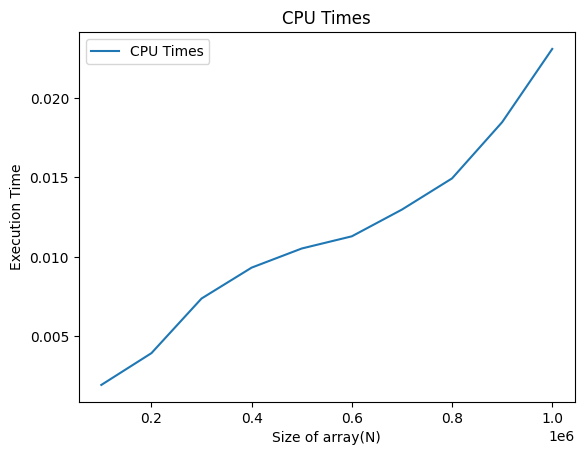

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
Atimes = np.array(times)
x = Atimes[:, 1]
y = Atimes[:, 0]
plt.plot(x, y, label="CPU Times")
plt.title('CPU Times')
plt.xlabel('Size of array(N)')
plt.ylabel('Execution Time')
plt.legend()
plt.show()

In [ ]:
!nvcc cuda/gpu.cu -o cuda/program
import subprocess
from subprocess import check_output

times2 = []

for i in range(100000, 1100000, 100000):
  media = 0
  for j in range(0, 100):
    time = check_output('./cuda/program ' + str(i), shell=True)
    media += float(time)
  times2.append((float(format(media/100, '.6f')), i))

print(times2)
!rm -rf ./cuda/program

[(1.9e-05, 100000), (2.2e-05, 200000), (2.3e-05, 300000), (2.4e-05, 400000), (2.3e-05, 500000), (2.2e-05, 600000), (2.3e-05, 700000), (2.2e-05, 800000), (2.3e-05, 900000), (2.6e-05, 1000000)]


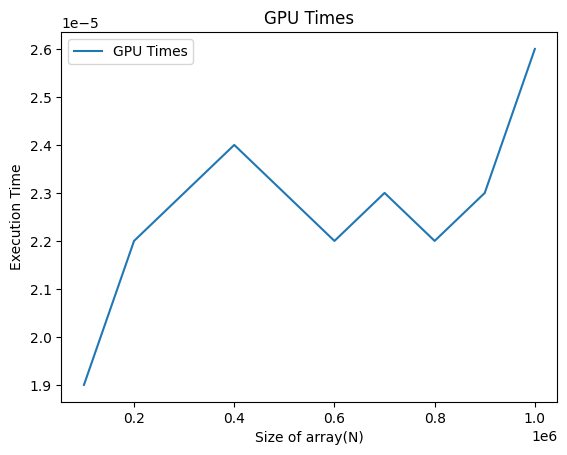

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
Btimes = np.array(times2)
x = Btimes[:, 1]
y = Btimes[:, 0]
plt.plot(x, y, label="GPU Times")
plt.title('GPU Times')
plt.xlabel('Size of array(N)')
plt.ylabel('Execution Time')
plt.legend()
plt.show()

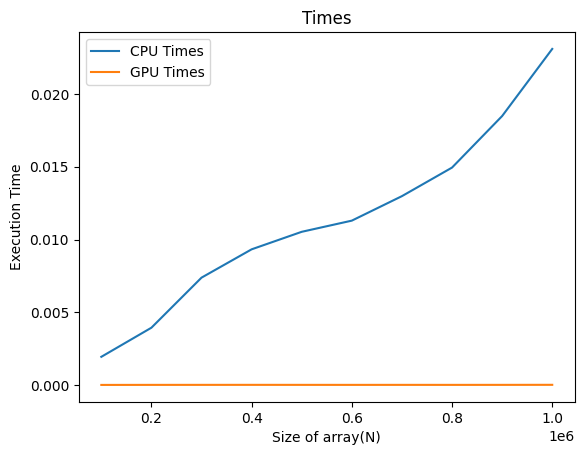

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
a = Atimes[:, 1]
b = Atimes[:, 0]
x = Btimes[:, 1]
y = Btimes[:, 0]
plt.plot(a, b, label="CPU Times")
plt.plot(x, y, label="GPU Times")
plt.title('Times')
plt.xlabel('Size of array(N)')
plt.ylabel('Execution Time')
plt.legend()
plt.show()

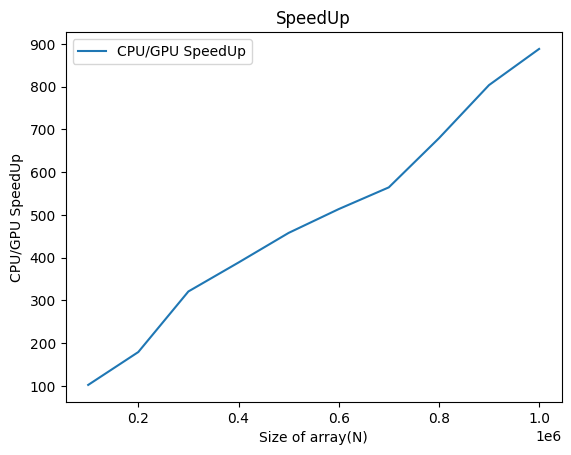

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
Btimes = np.array(times2)
x = Btimes[:, 1]
a = []
b = []
array = []
for i in Atimes[:, 0]:
  a.append(float(i))

for j in Btimes[:, 0]:
  b.append(float(j))

for i in range(len(a)):
  array.append(a[i]/b[i])

y = array
plt.plot(x, y, label="CPU/GPU SpeedUp")
plt.title('SpeedUp')
plt.xlabel('Size of array(N)')
plt.ylabel('CPU/GPU SpeedUp')
plt.legend()
plt.show()

In [ ]:
%%writefile cuda/greyScale.cu
#include <stdio.h>
#include <stdint.h>
#include <math.h>
#include <sys/time.h>
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"

static inline void getRGB(uint8_t *im, int width, int height, int nchannels, int x, int y, int *r, int *g, int *b)
{

    unsigned char *offset = im + (x + width * y) * nchannels;
    *r = offset[0];
    *g = offset[1];
    *b = offset[2];
}

int main(int nargs, char **argv)
{
    int width, height, nchannels;
    struct timeval fin,ini;

    if (nargs < 2)
    {
        printf("Usage: %s <image1> [<image2> ...]\n", argv[0]);
    }
    // For each image
    // Bucle 0
    for (int file_i = 1; file_i < nargs; file_i++)
    {
        printf("[info] Processing %s\n", argv[file_i]);
        /****** Reading file ******/
        uint8_t *rgb_image = stbi_load(argv[file_i], &width, &height, &nchannels, 4);
        if (!rgb_image)
        {
            perror("Image could not be opened");
        }

        /****** Allocating memory ******/
        // - RGB2Grey
        uint8_t *grey_image = malloc(width * height);
        if (!grey_image)
        {
            perror("Could not allocate memory");
        }

        // - Filenames
        for (int i = strlen(argv[file_i]) - 1; i >= 0; i--)
        {
            if (argv[file_i][i] == '.')
            {
                argv[file_i][i] = 0;
                break;
            }
        }

        char *grey_image_filename = 0;
        asprintf(&grey_image_filename, "%s_grey.jpg", argv[file_i]);
        if (!grey_image_filename)
        {
            perror("Could not allocate memory");
            exit(-1);
        }

        /****** Computations ******/
        printf("[info] %s: width=%d, height=%d, nchannels=%d\n", argv[file_i], width, height, nchannels);

        if (nchannels != 3 && nchannels != 4)
        {
            printf("[error] Num of channels=%d not supported. Only three (RGB), four (RGBA) are supported.\n", nchannels);
            continue;
        }

        gettimeofday(&ini,NULL);
        // RGB to grey scale
        int r, g, b;
        for (int i = 0; i < width; i++)
        {
            for (int j = 0; j < height; j++)
            {
                getRGB(rgb_image, width, height, 4, i, j, &r, &g, &b);
                grey_image[j * width + i] = (int)(0.2989 * r + 0.5870 * g + 0.1140 * b);
            }
        }

        stbi_write_jpg(grey_image_filename, width, height, 1, grey_image, 10);
        free(rgb_image);

        gettimeofday(&fin,NULL);

	printf("Tiempo: %f\n", ((fin.tv_sec*1000000+fin.tv_usec)-(ini.tv_sec*1000000+ini.tv_usec))*1.0/1000000.0);
        free(grey_image_filename);
    }
}

Writing cuda/greyScale.cu


# Ejercicio 2

In [ ]:
%%writefile cuda/greyScale.cu
#include <cuda.h>
#include <cuda_runtime.h>
#include <stdio.h>
#include <stdint.h>
#include <math.h>
#include <sys/time.h>
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"

#define NCHANNELS 4

__global__ void getRGB(uint8_t *im, int width, int height, int nchannels, uint8_t *grey_image)
{
    unsigned char *offset = im + (threadIdx.x + blockDim.x * blockIdx.x) * nchannels;
    int r = offset[0];
    int g = offset[1];
    int b = offset[2];
    grey_image[threadIdx.x + blockDim.x * blockIdx.x] = (int)(0.2989 * r + 0.5870 * g + 0.1140 * b);
}

int main(int nargs, char **argv)
{
    int width, height, nchannels;
    uint8_t *d_rgb_image, *d_grey_image;
    struct timeval fin,ini;

    if (nargs < 2)
    {
        printf("Usage: %s <image1> [<image2> ...]\n", argv[0]);
    }
    // For each image
    // Bucle 0
    for (int file_i = 1; file_i < nargs; file_i++)
    {
        printf("[info] Processing %s\n", argv[file_i]);
        /****** Reading file ******/
        uint8_t *rgb_image = stbi_load(argv[file_i], &width, &height, &nchannels, NCHANNELS);
        if (!rgb_image)
        {
            perror("Image could not be opened");
        }

        /****** Allocating memory ******/
        // - RGB2Grey
        uint8_t *grey_image = (uint8_t *)malloc(width * height);
        if (!grey_image)
        {
            perror("Could not allocate memory");
        }

        // Alloc space for device copy
        cudaMalloc((uint8_t **)&d_rgb_image, width*height*NCHANNELS);
        cudaMalloc((uint8_t **)&d_grey_image, width*height);

        // Copy to device
        cudaMemcpy(d_rgb_image, rgb_image, width*height*NCHANNELS, cudaMemcpyHostToDevice);

        // - Filenames
        for (int i = strlen(argv[file_i]) - 1; i >= 0; i--)
        {
            if (argv[file_i][i] == '.')
            {
                argv[file_i][i] = 0;
                break;
            }
        }

        char *grey_image_filename = 0;
        asprintf(&grey_image_filename, "%s_GPUgrey.jpg", argv[file_i]);
        if (!grey_image_filename)
        {
            perror("Could not allocate memory");
            exit(-1);
        }

        /****** Computations ******/
        printf("[info] %s: width=%d, height=%d, nchannels=%d\n", argv[file_i], width, height, nchannels);

        if (nchannels != 3 && nchannels != 4)
        {
            printf("[error] Num of channels=%d not supported. Only three (RGB), four (RGBA) are supported.\n", nchannels);
            continue;
        }

        // RGB to grey scale
        gettimeofday(&ini,NULL);
        getRGB<<<(width*height)/1024, 1024>>>(d_rgb_image, width, height, NCHANNELS, d_grey_image);
        gettimeofday(&fin,NULL);

        cudaMemcpy(grey_image, d_grey_image, width*height, cudaMemcpyDeviceToHost);

        stbi_write_jpg(grey_image_filename, width, height, 1, grey_image, 10);
        free(rgb_image);

	      printf("Tiempo: %f\n", ((fin.tv_sec*1000000+fin.tv_usec)-(ini.tv_sec*1000000+ini.tv_usec))*1.0/1000000.0);
        free(grey_image_filename);
    }
}

Overwriting cuda/greyScale.cu


In [ ]:
%%writefile cuda/greyScale-vect.c
#include <stdio.h>
#include <stdint.h>
#include <math.h>
#include <sys/time.h>
#define STB_IMAGE_IMPLEMENTATION
#include "stb_image.h"
#define STB_IMAGE_WRITE_IMPLEMENTATION
#include "stb_image_write.h"
#include <x86intrin.h>

/*static inline void getRGB(uint8_t *im, int width, int height, int nchannels, int x, int y, int *r, int *g, int *b)
{

    unsigned char *offset = im + (x + height * y) * nchannels;
    *r = offset[0];
    *g = offset[1];
    *b = offset[2];
}*/

int main(int nargs, char **argv)
{
    int width, height, nchannels;
    struct timeval fin,ini;

    if (nargs < 2)
    {
        printf("Usage: %s <image1> [<image2> ...]\n", argv[0]);
    }
    // For each image
    // Bucle 0
    for (int file_i = 1; file_i < nargs; file_i++)
    {
        printf("[info] Processing %s\n", argv[file_i]);
        /****** Reading file ******/
        uint8_t *rgb_image = stbi_load(argv[file_i], &width, &height, &nchannels, 4);
        if (!rgb_image)
        {
            perror("Image could not be opened");
        }

        /****** Allocating memory ******/
        // - RGB2Grey
        uint8_t *grey_image = malloc(width * height);
        if (!grey_image)
        {
            perror("Could not allocate memory");
        }

        // - Filenames
        for (int i = strlen(argv[file_i]) - 1; i >= 0; i--)
        {
            if (argv[file_i][i] == '.')
            {
                argv[file_i][i] = 0;
                break;
            }
        }

        char *grey_image_filename = 0;
        asprintf(&grey_image_filename, "%s_grey.jpg", argv[file_i]);
        if (!grey_image_filename)
        {
            perror("Could not allocate memory");
            exit(-1);
        }

        /****** Computations ******/
        printf("[info] %s: width=%d, height=%d, nchannels=%d\n", argv[file_i], width, height, nchannels);

        if (nchannels != 3 && nchannels != 4)
        {
            printf("[error] Num of channels=%d not supported. Only three (RGB), four (RGBA) are supported.\n", nchannels);
            continue;
        }

        gettimeofday(&ini,NULL);
        // RGB to grey scale
        //int r, g, b;
        __m256 coefficients = {0.2989f, 0.5870f, 0.1140f, 0.0, 0.2989f, 0.5870f, 0.1140f, 0.0}; //Coeficientes dados para la imagen
        __m256i offset = {0, 4, 1, 5, 0, 0, 0, 0}; //Estos valores los hemos sacado de la diapositiva 54.
        __m256 sol; // solucion
        __m128i grey;


        //Tenemos que cambiar el orden de los bucles, para que se usen posiciones contiguas en memoria y acelerar el proceso
        for (int j = 0; j < height; j+=4)
        {
            for (int i = 0; i < width; i+=4)
            {
                /*getRGB(rgb_image, width, height, 4, i, j, &r, &g, &b);
                grey_image[j * height + i] = (int)(0.2989 * r + 0.5870 * g + 0.1140 * b);*/

                //cargamos los vectores
                __m128i data1l = _mm_loadl_epi64((__m128i *)(rgb_image + (i + width * j) * 4));
                __m128i data1h = _mm_loadl_epi64((__m128i *)(rgb_image + (i + width * j) * 4 + 8));
                //Convertimos en integers de 32-bit
                __m256i data2l = _mm256_cvtepu8_epi32(data1l);
                __m256i data2h = _mm256_cvtepu8_epi32(data1h);
                //Convertimos dichos datos a float
                __m256 data3l = _mm256_cvtepi32_ps(data2l);
                __m256 data3h = _mm256_cvtepi32_ps(data2h);
                //Multiplicamos por el vector constante
                __m256 finall = _mm256_mul_ps(data3l, coefficients);
                __m256 finalh = _mm256_mul_ps(data3h, coefficients);
                //Sumamos horintalmente por pares de posiciones
                sol = _mm256_hadd_ps(finall, finalh);
                sol = _mm256_hadd_ps(sol, sol);
                //Reordenamos los valores de forma que quede como la diapositiva 54 de la presentacion-> ver comentario de offset
                sol = _mm256_permutevar8x32_ps(sol, offset);
                //Convertimos de nuevo a un integer de 32-bit
                grey = _mm_cvtps_epi32(_mm256_extractf128_ps(sol, 0));
                //Almacenamos la nueva imagen
                uint32_t *greyimage = (uint32_t *)&grey;
                *((uint32_t *)(&grey_image[j * width + i])) = *greyimage;
            }
        }

        gettimeofday(&fin,NULL);

        stbi_write_jpg(grey_image_filename, width, height, 1, grey_image, 10);
        free(rgb_image);


	printf("Tiempo: %f\n", ((fin.tv_sec*1000000+fin.tv_usec)-(ini.tv_sec*1000000+ini.tv_usec))*1.0/1000000.0);
        free(grey_image_filename);
    }
}

Writing cuda/greyScale-vect.c


In [ ]:
%cd cuda
!make all
!./greyScale /content/cuda/images/4k.jpg
!./greyScale-vect /content/cuda/images/4k.jpg
!make clean
%cd ..

/content/cuda
make: *** No rule to make target 'all'.  Stop.
/bin/bash: line 1: ./greyScale: No such file or directory
/bin/bash: line 1: ./greyScale-vect: No such file or directory
make: *** No rule to make target 'clean'.  Stop.
/content
